# Basic Text Classification with Naive Bayes
***

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster",font_scale=0.75)

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


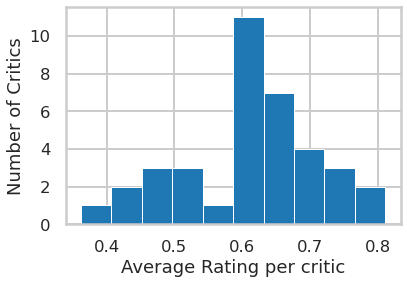

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

The distribution appears to be bimodal due one bin (0.55-0.60) consisting of fewer data points. Overall the distribution looks normal. Looks like a greater proportion of frequent reviewers tend to post more postive reviews than negative or neutral reviews (fresh vs rotten or none).

It indicates that if people like the movie, they are more likely to take time to write a review for it.

It also indicates that the total number of reviews a movie gets is a decent representation of that movie's general likeability among the audeince. Check the following two barplots. Movies that have recevied only 1 rating are highest in number. 
They are also those movies that have received lowest number of postive reviews.

### Text Processing Example

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [14]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

In [15]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def Xy_train_test_split(critics,vectorizer=None,test_size=0.33,random_state=42):
    train, test = train_test_split(critics[["quote","fresh"]],
                                   test_size=test_size, 
                                   random_state=random_state)
    if vectorizer is None:
        vectorizer = CountVectorizer()
    vectorizer.fit(train.quote)
    X_train = vectorizer.transform(train.quote)
    X_test = vectorizer.transform(test.quote)
    y_train = (train.fresh == 'fresh').values.astype(np.int)
    y_test = (test.fresh == 'fresh').values.astype(np.int)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = Xy_train_test_split(critics,test_size=0.33,random_state=42)
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)

print('Classification Report\n',classification_report(y_test,y_pred))
print('Confusion Report\n',confusion_matrix(y_test,y_pred))
print('\nf1-score:', f1_score(y_test,y_pred))
print('\nTrain accuracy:', mnb.score(X_train,y_train))
print('Test accuracy:', mnb.score(X_test,y_test))

Classification Report
               precision    recall  f1-score   support

           0       0.75      0.60      0.67      1968
           1       0.78      0.88      0.82      3168

    accuracy                           0.77      5136
   macro avg       0.76      0.74      0.75      5136
weighted avg       0.77      0.77      0.76      5136

Confusion Report
 [[1181  787]
 [ 392 2776]]

f1-score: 0.8248402911900163

Train accuracy: 0.9262350119904077
Test accuracy: 0.7704439252336449


Training accuracy is ~93%, but the test accuracy is only ~77%. There is high variance in the model which is why it is not generalizing well on the test set. 

Model can be futher tuned to perform better. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

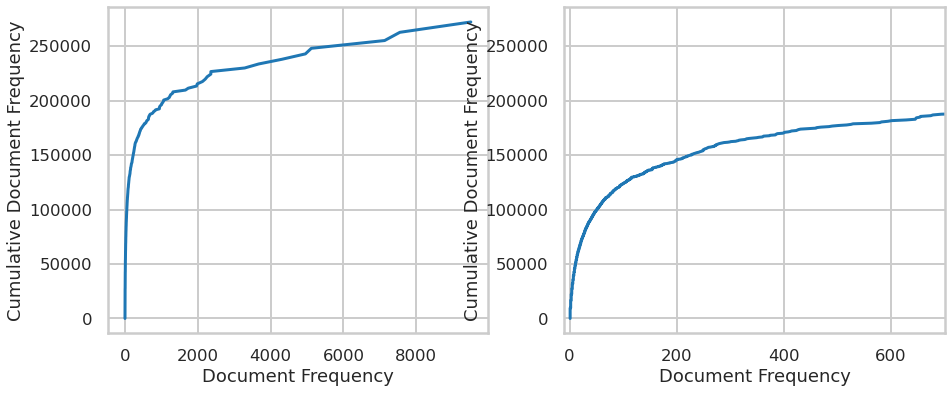

In [16]:
# Your turn.
doc_freq = (X.toarray() != 0).sum(axis=0)
cumsum = np.cumsum(np.sort(doc_freq))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
_=plt.plot(np.sort(doc_freq),cumsum)
_=plt.ylabel('Cumulative Document Frequency')
_=plt.xlabel('Document Frequency')
plt.subplot(1,2,2)
_=plt.plot(np.sort(doc_freq),cumsum)
_=plt.ylabel('Cumulative Document Frequency')
_=plt.xlabel('Document Frequency')
_=plt.xlim(-10,700)

From the slope plot on the right you can see that between *Slopes* = 5-10, the slope start becomes steeper rapidly.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [17]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [18]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [19]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

The log_likelihood score is the summed, log probability of the examples belonging to their true class. We are trying to optimize alpha by maximizing the log_likelihood score.

By incearing $\alpha$, we are increasing the global count of a particular feature. This adds more bias to the model. It helps in improving generalizability of the model, but bring down its overall performance (accuracy). 

In [20]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [5,6,7,8,10]
min_dfs = [3,6,7,8,9,20] # YOUR TURN: put your value of min_df here.
max_dfs = [360,640,700,740]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_max_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        for max_df in max_dfs:    
            vectorizer = CountVectorizer(min_df=min_df,max_df=max_df)       
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[~mask]
            ytrainthis = ythis[~mask]
            # your turn
            clf = MultinomialNB(alpha=alpha)
            score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
            if score > maxscore:
                maxscore = score
                best_alpha = alpha
                best_min_df = min_df
                best_max_df = max_df

In [21]:
print("alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))
print("max_df: {}".format(best_max_df))

alpha: 5
min_df: 8
max_df: 700


In [22]:
vectorizer = CountVectorizer(min_df=best_min_df,max_df=best_max_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[~mask]
ytrain=y[~mask]
xtest=X[mask]
ytest=y[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.828314
Accuracy on test data:     0.771686


In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1181  696]
 [ 370 2422]]


An alpha of 5 did mitigate high variance issue, but the training accuracy reduced by 10% compared to original model. However test accuracy only reduced by 1%, indicating that this model is more generalizable.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [24]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.91
            touching 0.90
         masterpiece 0.90
          remarkable 0.89
         intelligent 0.89
        entertaining 0.88
           excellent 0.87
                rare 0.87
         beautifully 0.86
              superb 0.86
Bad words	     P(fresh | word)
               fails 0.24
             problem 0.24
      disappointment 0.24
               bland 0.23
          uninspired 0.22
                dull 0.21
           pointless 0.20
       unfortunately 0.19
             unfunny 0.17
                lame 0.17


Probability of each row in the identity matrix represents the chance of classifying the review as "fresh". We can see that individual words that express positive emotions are enough to predict that the review belongs to the "fresh" class. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [25]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

Entrapment simply reminds us again how far Hollywood is from the true legacies of its greatest genre directors.

Mis-predicted Fresh quotes
--------------------------
It's inanely-scripted exploitation, sure, but this 'Halloween' doesn't trivialise; it even returns with sympathy to one victim minutes after the attack that has left her 

In [26]:
#your turn
xnew = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
print('Text: "This movie is not remarkable, touching, or superb in any way"\n')
print('Probability of beloging to, \n[0] rotten class: %.2f\n[1] fresh class: %.2f' %(tuple(clf.predict_proba(xnew).tolist()[0])))

Text: "This movie is not remarkable, touching, or superb in any way"

Probability of beloging to, 
[0] rotten class: 0.01
[1] fresh class: 0.99


Although the given text is a rotten review, it is classified as "fresh" because it has words like 'remarkable', 'touching, and 'superb' which indicate positive emotions. This is a shortcoming of naive bayes. It treats every word as an independent feature and ignores the emotion expressed in by a sequence of words.

### TF-IDF Weighting for Term Importance

In [48]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)